<a href="https://colab.research.google.com/github/camlab-bioml/2021_IMC_Jett/blob/main/DAMM_adam_07292021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.optim as optim
import torch.distributions as D

import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

from matplotlib.backends.backend_pdf import PdfPages

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def retFig(Q, ll):
  fig, axs = plt.subplots(2)
  axs[0].set_ylabel('Q')
  axs[1].set_ylabel('ll')
  #fig.suptitle('trial 2 cluster=3', fontsize=16)

  ## Q
  axs[0].plot(Q, 'r')
  ## L
  axs[1].plot(ll, 'b')
  return fig
  
def _ics(logL, n_obs, n_features, n_clusters): #, n, p, c
  params = n_clusters * (n_features**2 + n_features + 4) + (n_clusters * n_clusters - n_clusters)/2
  return 2 * (params - logL), -2 * logL + params * np.log(n_obs)
  
def generateData(n_clusters = 3, n_obs = 10000, n_features = 2):

  ## set ground true expressions ##

  true_expression_means = torch.tensor([
      [3, 5],
      [6, 7],
      [9, 11]
  ])
  
  #true_expression_means = torch.randint(1, 11, (n_clusters, n_features))
  #print(true_expression_means)

  true_expression_covs = torch.tensor([
      [[.1, 0], [0, .1]],
      [[.1, 0], [0, .1]],
      [[.1, 0], [0, .1]]
  ])

  true_size_means = torch.tensor([.1, .5, .7])
  #true_size_means = torch.rand(n_clusters)
  #print(true_size_means)

  true_size_stds = torch.tensor([.01, .01, .01])
  #true_size_stds

  ## other ground true for generating data ##
  d_ws = torch.tensor([.95, .05])
  
  #z_ws = torch.tensor([1 / 4, 1 / 2, 1 / 4])
  z_ws = np.random.rand(n_clusters)
  z_ws /= z_ws.sum()
  #print(z_ws.sum())

  #g_ws = torch.tensor([0.0667, 0.1333, 0.2000, 0.1000, 0.2667, 0.2333])
  n_events = int((n_clusters * n_clusters - n_clusters)/2 + n_clusters)
  g_ws = np.random.rand(n_events)
  g_ws /= g_ws.sum()
  #print(g_ws.sum())
  
  gs = np.sum(np.random.choice(2, size = n_obs, p = d_ws))
  zs = n_obs - gs

  ## simulate data
  x = np.zeros((zs, n_features+4))
  for i in range(zs):
    z = np.random.choice(n_clusters, size = 1, p = z_ws)[0]
    x[i] = np.append(np.random.multivariate_normal(true_expression_means[z], true_expression_covs[z]), [np.random.normal(true_size_means[z], true_size_stds[z]), 0, z, z+6])
  
  xxx = np.zeros((gs, n_features+4))
  for i in range(gs):

    g = np.random.choice(6, size = 1, p = g_ws)[0]
    
    if g == 0:
      idx = [0,0]
    elif g == 1:
      idx = [0,1]
    elif g == 2:
      idx = [0,2]
    elif g == 3:
      idx = [1,1]
    elif g == 4:
      idx = [1,2]
    else:
      idx = [2,2]
  
    xxx[i] = np.append(np.random.multivariate_normal( (true_expression_means[idx[0]] + true_expression_means[idx[1]])/2, (true_expression_covs[idx[0]] + true_expression_covs[idx[1]])/2 ),
                     [np.random.normal( (true_size_means[idx[0]] + true_size_means[idx[1]]), (true_size_stds[idx[0]] + true_size_stds[idx[1]]) ), 1, g, g])
  
  xx = np.append(x, xxx).reshape(n_obs,6)

  ## check number of points in each cluster
  for i in range(9):
    print(sum(xx[:,5] == i)/n_obs)
  
  print(gs)

  return torch.tensor(xx[:,:2]), torch.tensor(xx[:,2])

## initialization
def initialization(n_clusters, X, S):

  n_obs, n_features = X.shape

  #torch.manual_seed(seed_num)

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
  #pi_d0 = torch.tensor(0.9)
  pi_d0 = torch.tensor(np.random.uniform(.9, 1))
  
  pi_c = torch.empty(n_clusters).fill_(1. / (n_clusters))
  
  pi_cc = torch.triu(torch.ones(n_clusters, n_clusters))
  pi_cc = pi_cc / torch.sum(pi_cc)
  pi_cc[pi_cc == 0] = float('NaN')

  emu_c = X[np.random.choice(n_obs, n_clusters, replace=False)].float()

  '''
  emu_c = torch.tensor([
    [2, 6], # 1 2
    [5, 8], # 4 3
    [9, 10] #7 9
  ], dtype=torch.float) #, requires_grad=True, , device=device)
  '''

  smu_c = S[np.random.choice(n_obs, n_clusters, replace=False)].float()
  #smu_c = torch.tensor([.3, .5, .7], dtype=torch.float) #, requires_grad=True,  device=device)

  eco_c = 0.1 * torch.eye(n_features).tile(n_clusters, 1, 1)
  #eco_c = 0.1 * torch.ones(n_clusters, n_features, dtype=torch.float)
  sco_c = 0.01 * torch.ones(n_clusters, dtype=torch.float)

  smu_cc = torch.zeros(n_clusters, n_clusters, dtype=torch.float)
  sco_cc = torch.zeros(n_clusters, n_clusters, dtype=torch.float)

  emu_cc = torch.zeros(n_clusters, n_clusters, n_features, dtype=torch.float)
  eco_cc = torch.zeros(n_clusters, n_clusters, n_features, n_features, dtype=torch.float)

  for j in range(n_clusters):
    for k in range(n_clusters):
      if k >= j:
        smu_cc[j,k] = smu_c[j] + smu_c[k]
        sco_cc[j,k] = sco_c[j] + sco_c[k]

        emu_cc[j,k] = (emu_c[j] + emu_c[k])
        eco_cc[j,k] = (eco_c[j] + eco_c[k])

  params1 = [emu_c, eco_c, smu_c, sco_c, emu_cc, eco_cc, smu_cc, sco_cc]

  smu_c = torch.tensor(smu_c, requires_grad=True, dtype=torch.float, device=device)
  sco_c = torch.tensor(sco_c, requires_grad=True, dtype=torch.float, device=device)
      
  emu_c = torch.tensor(emu_c, requires_grad=True, dtype=torch.float, device=device)
  eco_c = torch.tensor(eco_c, requires_grad=True, dtype=torch.float, device=device)
      
  smu_cc = torch.tensor(smu_cc, requires_grad=True, dtype=torch.float, device=device)
  sco_cc = torch.tensor(sco_cc, requires_grad=True, dtype=torch.float, device=device)
      
  emu_cc = torch.tensor(emu_cc, requires_grad=True, dtype=torch.float, device=device)
  eco_cc = torch.tensor(eco_cc, requires_grad=True, dtype=torch.float, device=device)

  hyperparams = [pi_d0, pi_c, pi_cc]
  params2 = [emu_c, eco_c, smu_c, sco_c, emu_cc, eco_cc, smu_cc, sco_cc]

  return hyperparams, params1, params2

def _estimate_covariances_diag(X, n_c, resp, means, reg_covar=1e-6):
  
  avg_X2 = torch.mm(resp.T, X * X).T / n_c # pxc
  avg_means2 = means ** 2 # cxp
  avg_X_means = (means * torch.mm(resp.T, X)).T / n_c # pxc
  return avg_X2.T - 2 * avg_X_means.T + avg_means2 + reg_covar

def initial(n_clusters, X, S):

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  n_obs, n_features = X.shape
  
  num_components = int((n_clusters * n_clusters - n_clusters)/2 + 2*n_clusters)
  #kms = KMeans(num_components).fit(S.reshape(-1,1))
  
  gmm = GaussianMixture(num_components).fit(S.reshape(-1,1))
  preds = pd.DataFrame(gmm.predict(S.reshape(-1,1)))
  topkcounts = preds.value_counts().sort_values(ascending=False)
  #print(topkcounts)

  smu = torch.zeros(n_clusters, dtype=torch.float)
  sco = torch.zeros(n_clusters, dtype=torch.float)

  emu = torch.zeros(n_clusters, n_features, dtype=torch.float, )
  ecof = torch.zeros(n_clusters, n_features, n_features, dtype=torch.float)
  ecod = torch.zeros(n_clusters, n_features, dtype=torch.float)

  for j in range(n_clusters):
    svals = (np.array(S)[(preds == topkcounts.index.tolist()[j]).squeeze()])
    smu[j] = torch.tensor(svals.mean())
    sco[j] = torch.tensor(svals.std())

    evals = (np.array(X)[(preds == topkcounts.index.tolist()[j]).squeeze()])
    emu[j] = torch.tensor(evals.mean(0))

    ecof[j] = torch.tensor(np.cov(evals.T)) # full
    ecod[j] = torch.tensor(evals.std(0)) ## diag

  lambda_d0 = torch.tensor(topkcounts[:n_clusters].sum() / n_obs)
  pi_c = torch.tensor((topkcounts[:n_clusters] / n_obs).values)

  tau_cc = torch.triu(torch.ones(n_clusters, n_clusters, dtype=torch.float64))
  tau_cc[tau_cc == 0] = float('NaN')
  
  for j in range(n_clusters):
    for k in range(n_clusters):
      if not torch.isnan(tau_cc[j,k]):
        _, idx = abs((smu[j] + smu[k]) - gmm.means_).min(0)
        tau_cc[j,k] = (preds == idx).squeeze().sum() / n_obs

  hps = [lambda_d0, pi_c, tau_cc]
  ngps = [smu, sco, emu, ecof, ecod]

  smu = torch.tensor(smu, requires_grad=True, dtype=torch.float, device=device)
  sco = torch.tensor(sco, requires_grad=True, dtype=torch.float, device=device)

  emu = torch.tensor(emu, requires_grad=True, dtype=torch.float, device=device)
  ecof = torch.tensor(ecof, requires_grad=True, dtype=torch.float, device=device)
  ecod = torch.tensor(ecod, requires_grad=True, dtype=torch.float, device=device)

  return hps, ngps, [smu, sco, emu, ecof], [smu, sco, emu, ecod]

In [ ]:
## torch.optim version (function)
def em_v2(X, S, hyperparameters, parameters, n_epochs = 1000, tot = 1e-4):

  init_hps = hyperparameters
  init_params = parameters

  n_obs, n_features = X.shape
  n_clusters = len(hyperparameters[1])

  pi_d0 = hyperparameters[0]
  pi_d1 = 1-hyperparameters[0]
  pi_c = hyperparameters[1]
  pi_cc = hyperparameters[2]

  #opt = optim.SGD(parameters, lr=0.01)
  opt = optim.Adam(parameters)

  iter = 0
  qs = [0]
  ls = [float('-inf')]

  while iter < n_epochs:

    log_lambda0_pi = torch.log(pi_d0) + torch.log(pi_c)
    log_lambda1_tau = torch.log(1 - pi_d0) + torch.log(pi_cc)
  
    ### E-step:
    log_rd0z_top = torch.zeros(n_clusters, n_obs)
    log_rd1g_top = torch.zeros(n_clusters, n_clusters, n_obs)
  
    for j in range(n_clusters):

      sl0 = D.Normal(parameters[0][j], parameters[1][j]).log_prob(S.float())
      el0 = D.MultivariateNormal(parameters[2][j], parameters[3][j]).log_prob(X.float())

      log_rd0z_top[j] = log_lambda0_pi[j] + el0 + sl0
    
      for k in range(n_clusters):
        if torch.isnan(log_lambda1_tau[j,k]): #lower triangular nan
          log_rd1g_top[j,k] = float("NaN")
        else:

          sl1 = D.Normal((parameters[0][j] + parameters[0][k]), parameters[1][j] + parameters[1][k]).log_prob(S.float())
          el1 = D.MultivariateNormal((parameters[2][j] + parameters[2][k])/2, (parameters[3][j] + parameters[3][k])/2).log_prob(X.float())

          log_rd1g_top[j,k] = log_lambda1_tau[j,k] + el1 + sl1

    log_rd1g_top = log_rd1g_top.reshape(n_clusters * n_clusters, n_obs) #shape: (cxc')xn

    ignored_indices = torch.isnan(torch.logsumexp(log_rd1g_top, 1))
    assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)
    
    log_rdzg_norm = torch.logsumexp(torch.vstack((log_rd0z_top, log_rd1g_top[~ignored_indices])),0) #shape: n
    #log_rdzg_norm1 = torch.logsumexp(torch.vstack((torch.logsumexp(log_rd0z_top, 0), torch.logsumexp(log_rd1g_top[~ignored_indices],0))),0)

    L = log_rdzg_norm.mean()
    loss = -L
        
    opt.zero_grad()
    loss.backward()
    opt.step()

    if abs(ls[-1] - L) < tot:
      break

    if pi_d1 < tot or pi_d0 < tot:
      print("d is approaching 0! -> change a different initalization values")
      break

    with torch.no_grad():

      parameters[0].clamp_(tot)
      parameters[1].clamp_(tot)
      parameters[2].clamp_(tot)
      ##parameters[3].clamp_(tot)
      
      parameters[3] += torch.eye(n_features) * 0.01
      
      log_rdz = (log_rd0z_top - log_rdzg_norm).T #shape: nxc
      log_rdg = (log_rd1g_top - log_rdzg_norm).T #shape: nx(cxc')

      assert(torch.sum(torch.sum(torch.exp(log_rdz),1) + torch.sum(torch.exp(log_rdg[:,~ignored_indices]),1)).round() == n_obs)

      l1 = log_rd0z_top.T + log_rdz
      l2 = log_rd1g_top[~ignored_indices].T + log_rdg[:,~ignored_indices]; #l2[torch.isinf(l2)] = -100
      L1 = torch.vstack((torch.logsumexp(l1,1), torch.logsumexp(l2,1))).logsumexp(0).mean()

      q1 = log_rd0z_top.T * log_rdz.exp(); q1[torch.isnan(q1)] = 0.0
      q2 = log_rd1g_top[~ignored_indices].T * log_rdg[:,~ignored_indices].exp(); q2[torch.isnan(q2)] = 0.0
      Q = torch.vstack((torch.logsumexp(q1, 1), torch.logsumexp(q2, 1))).logsumexp(0).mean()

      qs.append(Q)
      ls.append(L)
      iter += 1

      rdz = torch.exp(log_rdz)    
      n_c = torch.sum(rdz, dim=0) #+ tot
      pi_c = n_c / n_obs
      pi_d0 = torch.sum(pi_c)

      rdg = torch.exp(log_rdg).reshape(n_obs, n_clusters, n_clusters)
      n_cc = torch.sum(rdg, dim=0)
      pi_cc = n_cc / n_obs
      pi_d1 = torch.sum(torch.triu(pi_cc))

  aic, bic = _ics(L, n_obs, n_features, n_clusters)

  print('# of clusters', n_clusters, 'Converged in Iteration', iter + 1, 'Likelihood: ', L, 'Likelihood1: ', L1, 'd0: ', pi_d0, 'BIC: ', bic, aic)
  return n_clusters, ls[1:], qs[1:], aic, bic, pi_d0, n_c, pi_c, pi_d1, n_cc, pi_cc, parameters, init_hps, init_params

#[3, 5],
#[6, 7],
#[9, 11]

In [ ]:
'''
#could add LowRankMultivariateNormal
k = 1
n_clusters = 3
n_features = 2
cov_facts = torch.rand(n_clusters, n_features, k, requires_grad=True, dtype=torch.float)
cov_diags = torch.tensor([
    [.1, .1],
    [.1, .1],
    [.1, .1]
], requires_grad=True, dtype=torch.float)
el0 = D.LowRankMultivariateNormal(emu_c[j], cov_facts[j], cov_diags[j]).log_prob(X.float())
'''
#cov_facts = torch.zeros(n_clusters, n_features, 1, requires_grad=True, dtype=torch.float)
#D.LowRankMultivariateNormal(inits[2][0][j], cov_facts[j], cov_diags[j]).log_prob(X.float())
#cov_facts[j] @ cov_facts[j].T + torch.eye(n_features) * cov_diags[j]

## torch.optim version (function)
def em_v3(X, S, hyperparameters, parameters, n_epochs = 1000, tot = 1e-4):

  init_hps = hyperparameters
  init_params = parameters

  n_obs, n_features = X.shape
  n_clusters = len(hyperparameters[1])

  pi_d0 = hyperparameters[0]
  pi_d1 = 1-hyperparameters[0]
  pi_c = hyperparameters[1]
  pi_cc = hyperparameters[2]

  #opt = optim.SGD(parameters, lr=0.01)
  opt = optim.Adam(parameters)

  cov_facts = torch.zeros(n_clusters, n_features, 1, requires_grad=False, dtype=torch.float)

  iter = 0
  qs = [0]
  ls = [float('-inf')]

  while iter < n_epochs:

    log_lambda0_pi = torch.log(pi_d0) + torch.log(pi_c)
    log_lambda1_tau = torch.log(1 - pi_d0) + torch.log(pi_cc)
  
    ### E-step:
    log_rd0z_top = torch.zeros(n_clusters, n_obs)
    log_rd1g_top = torch.zeros(n_clusters, n_clusters, n_obs)
  
    for j in range(n_clusters):

      sl0 = D.Normal(parameters[0][j], parameters[1][j]).log_prob(S.float())
      el0 = D.LowRankMultivariateNormal(parameters[2][j], cov_facts[j], parameters[3][j]).log_prob(X.float())

      log_rd0z_top[j] = log_lambda0_pi[j] + el0 + sl0
    
      for k in range(n_clusters):
        if torch.isnan(log_lambda1_tau[j,k]): #lower triangular nan
          log_rd1g_top[j,k] = float("NaN")
        else:
          sl1 = D.Normal((parameters[0][j] + parameters[0][k]), parameters[1][j] + parameters[1][k]).log_prob(S.float())
          el1 = D.LowRankMultivariateNormal((parameters[2][j] + parameters[2][k]), cov_facts[j] + cov_facts[k], (parameters[3][j] + parameters[3][k])).log_prob(X.float())

          log_rd1g_top[j,k] = log_lambda1_tau[j,k] + el1 + sl1

    log_rd1g_top = log_rd1g_top.reshape(n_clusters * n_clusters, n_obs) #shape: (cxc')xn

    ignored_indices = torch.isnan(torch.logsumexp(log_rd1g_top, 1))
    assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)
    
    log_rdzg_norm = torch.logsumexp(torch.vstack((log_rd0z_top, log_rd1g_top[~ignored_indices])),0) #shape: n
    #log_rdzg_norm1 = torch.logsumexp(torch.vstack((torch.logsumexp(log_rd0z_top, 0), torch.logsumexp(log_rd1g_top[~ignored_indices],0))),0)

    L = log_rdzg_norm.mean()
    loss = -L
        
    opt.zero_grad()
    loss.backward()
    opt.step()

    if abs(ls[-1] - L) < tot:
      break

    if pi_d1 < tot or pi_d0 < tot:
      print("d is approaching 0! -> change a different initalization values")
      break

    with torch.no_grad():
      
      parameters[0].clamp_(tot)
      parameters[1].clamp_(tot)
      parameters[2].clamp_(tot)
      parameters[3].clamp_(tot)

      log_rdz = (log_rd0z_top - log_rdzg_norm).T #shape: nxc
      log_rdg = (log_rd1g_top - log_rdzg_norm).T #shape: nx(cxc')

      assert(torch.sum(torch.sum(torch.exp(log_rdz),1) + torch.sum(torch.exp(log_rdg[:,~ignored_indices]),1)).round() == n_obs)

      l1 = log_rd0z_top.T + log_rdz
      l2 = log_rd1g_top[~ignored_indices].T + log_rdg[:,~ignored_indices]; #l2[torch.isinf(l2)] = -100
      L1 = torch.vstack((torch.logsumexp(l1,1), torch.logsumexp(l2,1))).logsumexp(0).mean()

      q1 = log_rd0z_top.T * log_rdz.exp(); q1[torch.isnan(q1)] = 0.0
      q2 = log_rd1g_top[~ignored_indices].T * log_rdg[:,~ignored_indices].exp(); q2[torch.isnan(q2)] = 0.0
      Q = torch.vstack((torch.logsumexp(q1, 1), torch.logsumexp(q2, 1))).logsumexp(0).mean()

      qs.append(Q)
      ls.append(L)
      iter += 1

      rdz = torch.exp(log_rdz)    
      n_c = torch.sum(rdz, dim=0) #+ tot
      pi_c = n_c / n_obs
      pi_d0 = torch.sum(pi_c)

      rdg = torch.exp(log_rdg).reshape(n_obs, n_clusters, n_clusters)
      n_cc = torch.sum(rdg, dim=0)
      pi_cc = n_cc / n_obs
      pi_d1 = torch.sum(torch.triu(pi_cc))

  aic, bic = _ics(L, n_obs, n_features, n_clusters)

  print('# of clusters', n_clusters, 'Converged in Iteration', iter + 1, 'Likelihood: ', L, 'Likelihood1: ', L1, 'd0: ', pi_d0, 'BIC: ', bic, aic)
  return n_clusters, ls[1:], qs[1:], aic, bic, pi_d0, n_c, pi_c, pi_d1, n_cc, pi_cc, parameters, init_hps, init_params

#[3, 5],
#[6, 7],
#[9, 11]

In [ ]:
#X, S = generateData(3, 10000, 2)
#inits = initial(3, X, S)
#fit1 = em_v2(X, S, inits[0], inits[2], 1000)
#fit2 = em_v3(X, S, inits[0], inits[3], 1000)

0.0047
0.0015
0.0062
0.0055
0.0139
0.0171
0.393
0.4485
0.1096
489


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

d is approaching 0! -> change a different initalization values
# of clusters 1 Converged in Iteration 5 Likelihood:  tensor(-6.8253, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-6.8433) d0:  tensor(1.0000) BIC:  tensor(105.7539, grad_fn=<AddBackward0>) tensor(33.6505, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 2 Converged in Iteration 520 Likelihood:  tensor(-1.1528, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-1.1530) d0:  tensor(0.8594) BIC:  tensor(195.7228, grad_fn=<AddBackward0>) tensor(44.3056, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 3 Converged in Iteration 1001 Likelihood:  tensor(0.1591, grad_fn=<MeanBackward0>) Likelihood1:  tensor(0.1546) d0:  tensor(0.8513) BIC:  tensor(303.6230, grad_fn=<AddBackward0>) tensor(65.6818, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 4 Converged in Iteration 1001 Likelihood:  tensor(0.9434, grad_fn=<MeanBackward0>) Likelihood1:  tensor(0.9401) d0:  tensor(0.9702) BIC:  tensor(421.7888, grad_fn=<AddBackward0>) tensor(90.1132, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 5 Converged in Iteration 1001 Likelihood:  tensor(0.2640, grad_fn=<MeanBackward0>) Likelihood1:  tensor(0.2601) d0:  tensor(0.8477) BIC:  tensor(552.0923, grad_fn=<AddBackward0>) tensor(119.4719, grad_fn=<MulBackward0>)
0.0196
0.0132
0.0098
0.0017
0.0057
0.0003
0.4716
0.3599
0.1182
503


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

d is approaching 0! -> change a different initalization values
# of clusters 1 Converged in Iteration 6 Likelihood:  tensor(-7.8394, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-7.8845) d0:  tensor(0.9999) BIC:  tensor(107.7823, grad_fn=<AddBackward0>) tensor(35.6789, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 2 Converged in Iteration 556 Likelihood:  tensor(-0.6348, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-0.6349) d0:  tensor(0.8758) BIC:  tensor(194.6868, grad_fn=<AddBackward0>) tensor(43.2696, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 3 Converged in Iteration 265 Likelihood:  tensor(-0.0457, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-0.0459) d0:  tensor(0.9825) BIC:  tensor(304.0327, grad_fn=<AddBackward0>) tensor(66.0915, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 4 Converged in Iteration 715 Likelihood:  tensor(0.4328, grad_fn=<MeanBackward0>) Likelihood1:  tensor(0.4282) d0:  tensor(0.8643) BIC:  tensor(422.8101, grad_fn=<AddBackward0>) tensor(91.1344, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 5 Converged in Iteration 786 Likelihood:  tensor(0.4350, grad_fn=<MeanBackward0>) Likelihood1:  tensor(0.4296) d0:  tensor(0.8643) BIC:  tensor(551.7504, grad_fn=<AddBackward0>) tensor(119.1300, grad_fn=<MulBackward0>)
0.0081
0.0101
0.0068
0.0079
0.0124
0.0056
0.3841
0.3113
0.2537
509


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

d is approaching 0! -> change a different initalization values
# of clusters 1 Converged in Iteration 3 Likelihood:  tensor(-8.2480, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-8.2883) d0:  tensor(1.0000) BIC:  tensor(108.5994, grad_fn=<AddBackward0>) tensor(36.4960, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 2 Converged in Iteration 564 Likelihood:  tensor(-1.5186, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-1.5192) d0:  tensor(0.7283) BIC:  tensor(196.4543, grad_fn=<AddBackward0>) tensor(45.0371, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 3 Converged in Iteration 466 Likelihood:  tensor(-0.1573, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-0.1582) d0:  tensor(0.9828) BIC:  tensor(304.2558, grad_fn=<AddBackward0>) tensor(66.3145, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 4 Converged in Iteration 1001 Likelihood:  tensor(0.9256, grad_fn=<MeanBackward0>) Likelihood1:  tensor(0.9228) d0:  tensor(0.9944) BIC:  tensor(421.8245, grad_fn=<AddBackward0>) tensor(90.1488, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 5 Converged in Iteration 1001 Likelihood:  tensor(0.8343, grad_fn=<MeanBackward0>) Likelihood1:  tensor(0.8294) d0:  tensor(0.9762) BIC:  tensor(550.9518, grad_fn=<AddBackward0>) tensor(118.3314, grad_fn=<MulBackward0>)
0.0043
0.007
0.0118
0.0095
0.0018
0.017
0.1986
0.2573
0.4927
514


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

d is approaching 0! -> change a different initalization values
# of clusters 1 Converged in Iteration 3 Likelihood:  tensor(-7.0610, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-7.0825) d0:  tensor(1.) BIC:  tensor(106.2254, grad_fn=<AddBackward0>) tensor(34.1220, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 2 Converged in Iteration 1001 Likelihood:  tensor(-2.8430, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-2.8449) d0:  tensor(0.9724) BIC:  tensor(199.1032, grad_fn=<AddBackward0>) tensor(47.6860, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

d is approaching 0! -> change a different initalization values
# of clusters 3 Converged in Iteration 628 Likelihood:  tensor(-3.6695, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-3.6797) d0:  tensor(0.9999) BIC:  tensor(311.2803, grad_fn=<AddBackward0>) tensor(73.3391, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

d is approaching 0! -> change a different initalization values
# of clusters 4 Converged in Iteration 809 Likelihood:  tensor(-3.1762, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-3.1945) d0:  tensor(1.0000) BIC:  tensor(430.0280, grad_fn=<AddBackward0>) tensor(98.3523, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 5 Converged in Iteration 511 Likelihood:  tensor(0.1631, grad_fn=<MeanBackward0>) Likelihood1:  tensor(0.1625) d0:  tensor(0.9820) BIC:  tensor(552.2942, grad_fn=<AddBackward0>) tensor(119.6738, grad_fn=<MulBackward0>)
0.0026
0.0156
0.0141
0.0065
0.0125
0.0009
0.409
0.4711
0.0677
522


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

d is approaching 0! -> change a different initalization values
# of clusters 1 Converged in Iteration 21 Likelihood:  tensor(-6.5964, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-6.6221) d0:  tensor(0.9999) BIC:  tensor(105.2963, grad_fn=<AddBackward0>) tensor(33.1929, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourc

# of clusters 2 Converged in Iteration 335 Likelihood:  tensor(-0.7186, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-0.7191) d0:  tensor(0.9189) BIC:  tensor(194.8543, grad_fn=<AddBackward0>) tensor(43.4372, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourc

# of clusters 3 Converged in Iteration 273 Likelihood:  tensor(-0.2720, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-0.2723) d0:  tensor(0.9866) BIC:  tensor(304.4852, grad_fn=<AddBackward0>) tensor(66.5440, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourc

# of clusters 4 Converged in Iteration 1001 Likelihood:  tensor(0.5960, grad_fn=<MeanBackward0>) Likelihood1:  tensor(0.5940) d0:  tensor(0.8983) BIC:  tensor(422.4837, grad_fn=<AddBackward0>) tensor(90.8080, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourc

# of clusters 5 Converged in Iteration 1001 Likelihood:  tensor(0.5845, grad_fn=<MeanBackward0>) Likelihood1:  tensor(0.5809) d0:  tensor(0.8983) BIC:  tensor(551.4515, grad_fn=<AddBackward0>) tensor(118.8311, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


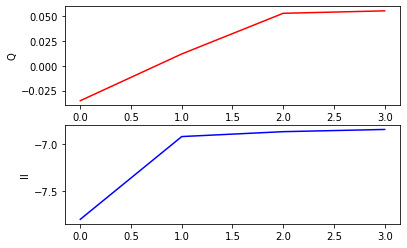

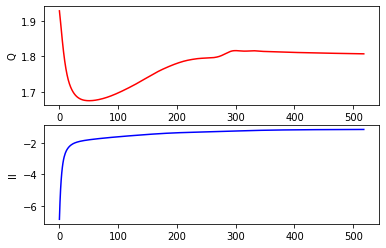

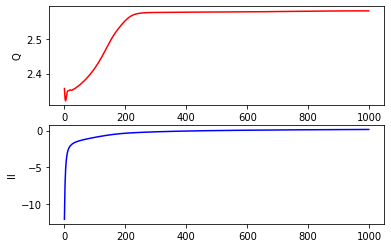

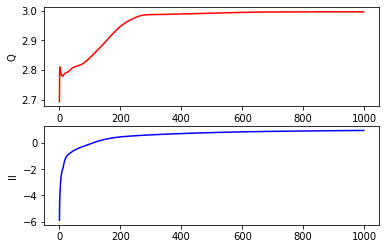

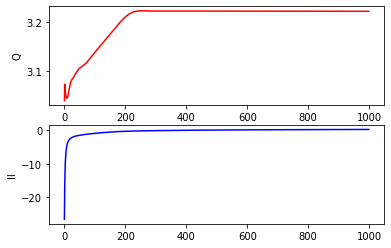

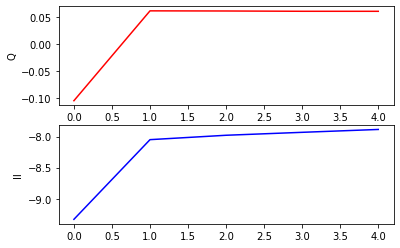

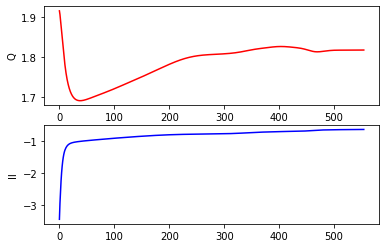

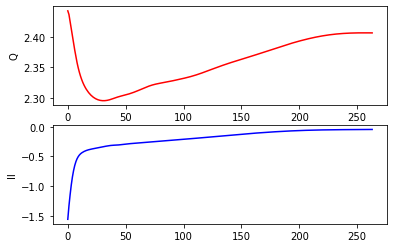

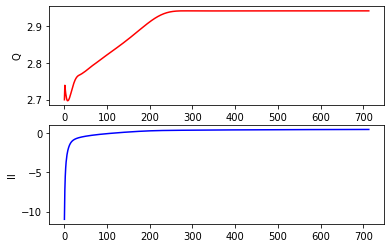

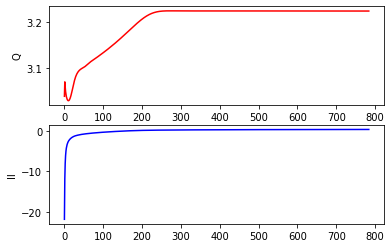

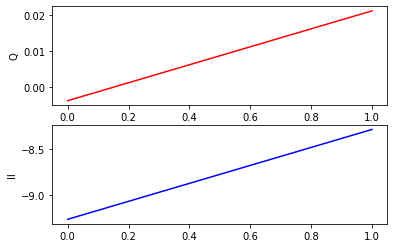

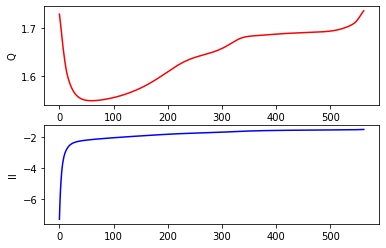

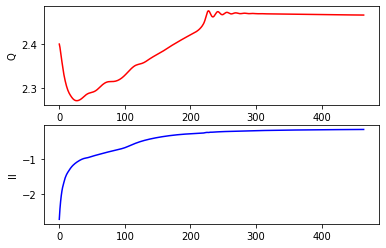

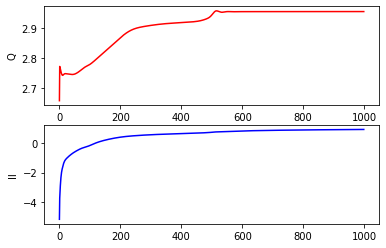

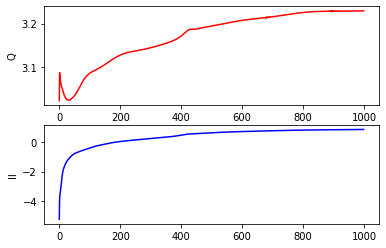

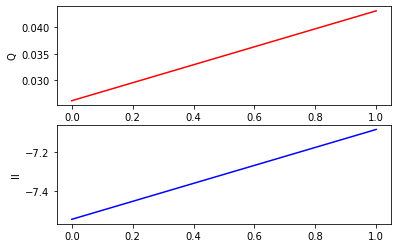

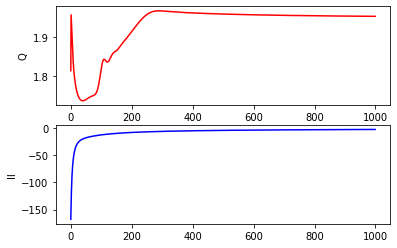

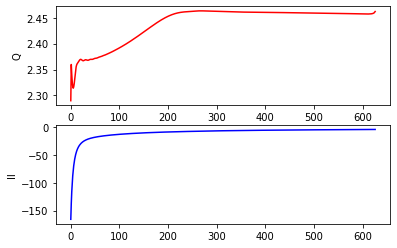

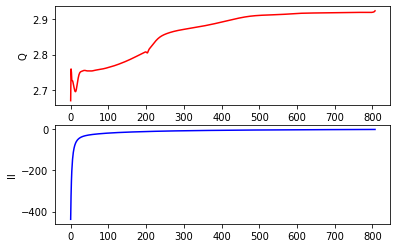

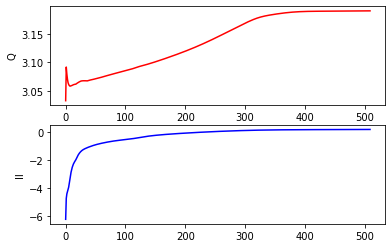

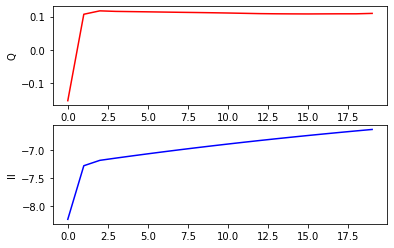

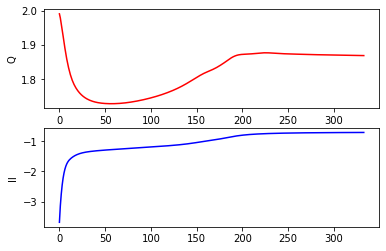

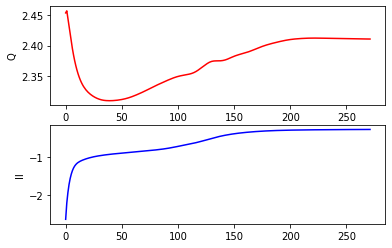

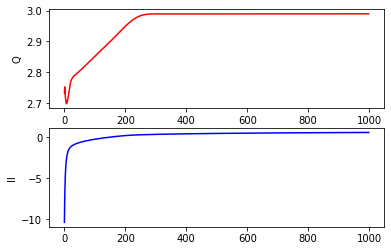

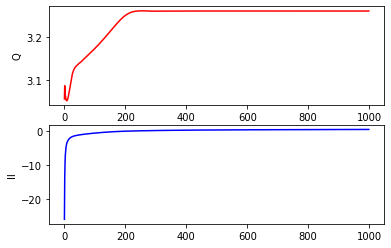

In [ ]:
n_trials = 5
history = []
pp = PdfPages('p4.pdf')
for trial in range(n_trials):
  X, S = generateData(3, 10000, 2)
  for sn_clust in range(1, 6):
    inits = initial(sn_clust, X, S)
    #fit1 = em_v2(X, S, inits[0], inits[2], 1000) #full
    fit2 = em_v3(X, S, inits[0], inits[3], 1000) #diag
    history.append(fit2)
    pp.savefig(retFig(fit2[2], fit2[1])) ##Q, L
pp.close()

In [ ]:
import torch
import torch.optim as optim
import torch.distributions as D

import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

from matplotlib.backends.backend_pdf import PdfPages

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def retFig(Q, ll):
  fig, axs = plt.subplots(2)
  axs[0].set_ylabel('Q')
  axs[1].set_ylabel('ll')
  #fig.suptitle('trial 2 cluster=3', fontsize=16)

  ## Q
  axs[0].plot(Q, 'r')
  ## L
  axs[1].plot(ll, 'b')
  return fig
  
def _ics(logL, n_obs, n_features, n_clusters): #, n, p, c
  params = n_clusters * (n_features**2 + n_features + 4) + (n_clusters * n_clusters - n_clusters)/2
  return 2 * (params - logL), -2 * logL + params * np.log(n_obs)
  
## initialization
def initialization(n_clusters, X, S):

  n_obs, n_features = X.shape

  #torch.manual_seed(seed_num)

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
  #pi_d0 = torch.tensor(0.9)
  pi_d0 = torch.tensor(np.random.uniform(.9, 1))
  
  pi_c = torch.empty(n_clusters).fill_(1. / (n_clusters))
  
  pi_cc = torch.triu(torch.ones(n_clusters, n_clusters))
  pi_cc = pi_cc / torch.sum(pi_cc)
  pi_cc[pi_cc == 0] = float('NaN')

  emu_c = X[np.random.choice(n_obs, n_clusters, replace=False)].float()

  '''
  emu_c = torch.tensor([
    [2, 6], # 1 2
    [5, 8], # 4 3
    [9, 10] #7 9
  ], dtype=torch.float) #, requires_grad=True, , device=device)
  '''

  smu_c = S[np.random.choice(n_obs, n_clusters, replace=False)].float()
  #smu_c = torch.tensor([.3, .5, .7], dtype=torch.float) #, requires_grad=True,  device=device)

  eco_c = 0.1 * torch.eye(n_features).tile(n_clusters, 1, 1)
  #eco_c = 0.1 * torch.ones(n_clusters, n_features, dtype=torch.float)
  sco_c = 0.01 * torch.ones(n_clusters, dtype=torch.float)

  smu_cc = torch.zeros(n_clusters, n_clusters, dtype=torch.float)
  sco_cc = torch.zeros(n_clusters, n_clusters, dtype=torch.float)

  emu_cc = torch.zeros(n_clusters, n_clusters, n_features, dtype=torch.float)
  eco_cc = torch.zeros(n_clusters, n_clusters, n_features, n_features, dtype=torch.float)

  for j in range(n_clusters):
    for k in range(n_clusters):
      if k >= j:
        smu_cc[j,k] = smu_c[j] + smu_c[k]
        sco_cc[j,k] = sco_c[j] + sco_c[k]

        emu_cc[j,k] = (emu_c[j] + emu_c[k])
        eco_cc[j,k] = (eco_c[j] + eco_c[k])

  params1 = [emu_c, eco_c, smu_c, sco_c, emu_cc, eco_cc, smu_cc, sco_cc]

  smu_c = torch.tensor(smu_c, requires_grad=True, dtype=torch.float, device=device)
  sco_c = torch.tensor(sco_c, requires_grad=True, dtype=torch.float, device=device)
      
  emu_c = torch.tensor(emu_c, requires_grad=True, dtype=torch.float, device=device)
  eco_c = torch.tensor(eco_c, requires_grad=True, dtype=torch.float, device=device)
      
  smu_cc = torch.tensor(smu_cc, requires_grad=True, dtype=torch.float, device=device)
  sco_cc = torch.tensor(sco_cc, requires_grad=True, dtype=torch.float, device=device)
      
  emu_cc = torch.tensor(emu_cc, requires_grad=True, dtype=torch.float, device=device)
  eco_cc = torch.tensor(eco_cc, requires_grad=True, dtype=torch.float, device=device)

  hyperparams = [pi_d0, pi_c, pi_cc]
  params2 = [emu_c, eco_c, smu_c, sco_c, emu_cc, eco_cc, smu_cc, sco_cc]

  return hyperparams, params1, params2

def _estimate_covariances_diag(X, n_c, resp, means, reg_covar=1e-6):
  
  avg_X2 = torch.mm(resp.T, X * X).T / n_c # pxc
  avg_means2 = means ** 2 # cxp
  avg_X_means = (means * torch.mm(resp.T, X)).T / n_c # pxc
  return avg_X2.T - 2 * avg_X_means.T + avg_means2 + reg_covar

def initial(n_clusters, X, S):

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  n_obs, n_features = X.shape
  
  num_components = int((n_clusters * n_clusters - n_clusters)/2 + 2*n_clusters)
  #kms = KMeans(num_components).fit(S.reshape(-1,1))
  
  gmm = GaussianMixture(num_components).fit(S.reshape(-1,1))
  preds = pd.DataFrame(gmm.predict(S.reshape(-1,1)))
  topkcounts = preds.value_counts().sort_values(ascending=False)
  #print(topkcounts)

  smu = torch.zeros(n_clusters, dtype=torch.float)
  sco = torch.zeros(n_clusters, dtype=torch.float)

  emu = torch.zeros(n_clusters, n_features, dtype=torch.float, )
  ecof = torch.zeros(n_clusters, n_features, n_features, dtype=torch.float)
  ecod = torch.zeros(n_clusters, n_features, dtype=torch.float)

  for j in range(n_clusters):
    svals = (np.array(S)[(preds == topkcounts.index.tolist()[j]).squeeze()])
    smu[j] = torch.tensor(svals.mean())
    sco[j] = torch.tensor(svals.std())

    evals = (np.array(X)[(preds == topkcounts.index.tolist()[j]).squeeze()])
    emu[j] = torch.tensor(evals.mean(0))

    ecof[j] = torch.tensor(np.cov(evals.T)) # full
    ecod[j] = torch.tensor(evals.std(0)) ## diag


  ss = torch.sort(smu, 0) ## sort cell size
  smu = smu[ss.indices]
  sco = sco[ss.indices]

  es = torch.sort(emu, 0) ## sort expressions
  emu = emu[es.indices[:,0]]
  emuf = ecof[es.indices[:,0]]
  emud = ecod[es.indices[:,0]]

  lambda_d0 = torch.tensor(topkcounts[:n_clusters].sum() / n_obs)
  pi_c = torch.tensor((topkcounts[:n_clusters] / n_obs).values)

  tau_cc = torch.triu(torch.ones(n_clusters, n_clusters, dtype=torch.float64))
  tau_cc[tau_cc == 0] = float('NaN')
  
  for j in range(n_clusters):
    for k in range(n_clusters):
      if not torch.isnan(tau_cc[j,k]):
        _, idx = abs((smu[j] + smu[k]) - gmm.means_).min(0)
        tau_cc[j,k] = (preds == idx).squeeze().sum() / n_obs

  hps = [lambda_d0, pi_c, tau_cc]
  ngps = [smu, sco, emu, ecof, ecod]

  smu = torch.tensor(smu, requires_grad=True, dtype=torch.float, device=device)
  sco = torch.tensor(sco, requires_grad=True, dtype=torch.float, device=device)

  emu = torch.tensor(emu, requires_grad=True, dtype=torch.float, device=device)
  ecof = torch.tensor(ecof, requires_grad=True, dtype=torch.float, device=device)
  ecod = torch.tensor(ecod, requires_grad=True, dtype=torch.float, device=device)

  return hps, ngps, [smu, sco, emu, ecof], [smu, sco, emu, ecod]

In [ ]:
'''
#could add LowRankMultivariateNormal
k = 1
n_clusters = 3
n_features = 2
cov_facts = torch.rand(n_clusters, n_features, k, requires_grad=True, dtype=torch.float)
cov_diags = torch.tensor([
    [.1, .1],
    [.1, .1],
    [.1, .1]
], requires_grad=True, dtype=torch.float)
el0 = D.LowRankMultivariateNormal(emu_c[j], cov_facts[j], cov_diags[j]).log_prob(X.float())
'''
#cov_facts = torch.zeros(n_clusters, n_features, 1, requires_grad=True, dtype=torch.float)
#D.LowRankMultivariateNormal(inits[2][0][j], cov_facts[j], cov_diags[j]).log_prob(X.float())
#cov_facts[j] @ cov_facts[j].T + torch.eye(n_features) * cov_diags[j]

## torch.optim version (function)
def em_v3(X, S, hyperparameters, parameters, n_epochs = 1000, tot = 1e-4):

  n_obs, n_features = X.shape
  n_clusters = len(hyperparameters[1])

  pi_d0 = hyperparameters[0]
  pi_d1 = 1-hyperparameters[0]
  pi_c = hyperparameters[1]
  pi_cc = hyperparameters[2]

  #opt = optim.SGD(parameters, lr=0.01)
  opt = optim.Adam(parameters)

  cov_facts = torch.zeros(n_clusters, n_features, 1, requires_grad=False, dtype=torch.float)

  iter = 0
  qs = [0]
  ls = [float('-inf')]

  while iter < n_epochs:

    log_lambda0_pi = torch.log(pi_d0) + torch.log(pi_c)
    log_lambda1_tau = torch.log(1 - pi_d0) + torch.log(pi_cc)
  
    ### E-step:
    log_rd0z_top = torch.zeros(n_clusters, n_obs)
    log_rd1g_top = torch.zeros(n_clusters, n_clusters, n_obs)
  
    for j in range(n_clusters):

      sl0 = D.Normal(parameters[0][j], parameters[1][j]).log_prob(S.float())
      el0 = D.LowRankMultivariateNormal(parameters[2][j], cov_facts[j], parameters[3][j]).log_prob(X.float())

      log_rd0z_top[j] = log_lambda0_pi[j] + el0 + sl0
    
      for k in range(n_clusters):
        if torch.isnan(log_lambda1_tau[j,k]): #lower triangular nan
          log_rd1g_top[j,k] = float("NaN")
        else:
          sl1 = D.Normal((parameters[0][j] + parameters[0][k]), parameters[1][j] + parameters[1][k]).log_prob(S.float())
          el1 = D.LowRankMultivariateNormal((parameters[2][j] + parameters[2][k])/2, cov_facts[j] + cov_facts[k], (parameters[3][j] + parameters[3][k])/2).log_prob(X.float())

          log_rd1g_top[j,k] = log_lambda1_tau[j,k] + el1 + sl1

    log_rd1g_top = log_rd1g_top.reshape(n_clusters * n_clusters, n_obs) #shape: (cxc')xn

    ignored_indices = torch.isnan(torch.logsumexp(log_rd1g_top, 1))
    assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)
    
    log_rdzg_norm = torch.logsumexp(torch.vstack((log_rd0z_top, log_rd1g_top[~ignored_indices])),0) #shape: n
    #log_rdzg_norm1 = torch.logsumexp(torch.vstack((torch.logsumexp(log_rd0z_top, 0), torch.logsumexp(log_rd1g_top[~ignored_indices],0))),0)

    L = log_rdzg_norm.mean()
    loss = -L
        
    opt.zero_grad()
    loss.backward()
    opt.step()

    if abs(ls[-1] - L) < tot:
      break

    if pi_d1 < tot or pi_d0 < tot:
      print("d is approaching 0! -> change a different initalization values")
      break

    with torch.no_grad():
      
      parameters[0].clamp_(tot)
      parameters[1].clamp_(tot)
      parameters[2].clamp_(tot)
      parameters[3].clamp_(tot)

      log_rdz = (log_rd0z_top - log_rdzg_norm).T #shape: nxc
      log_rdg = (log_rd1g_top - log_rdzg_norm).T #shape: nx(cxc')

      assert(torch.sum(torch.sum(torch.exp(log_rdz),1) + torch.sum(torch.exp(log_rdg[:,~ignored_indices]),1)).round() == n_obs)

      l1 = log_rd0z_top.T + log_rdz
      l2 = log_rd1g_top[~ignored_indices].T + log_rdg[:,~ignored_indices]; #l2[torch.isinf(l2)] = -100
      L1 = torch.vstack((torch.logsumexp(l1,1), torch.logsumexp(l2,1))).logsumexp(0).mean()

      q1 = log_rd0z_top.T * log_rdz.exp(); q1[torch.isnan(q1)] = 0.0
      q2 = log_rd1g_top[~ignored_indices].T * log_rdg[:,~ignored_indices].exp(); q2[torch.isnan(q2)] = 0.0
      Q = torch.vstack((torch.logsumexp(q1, 1), torch.logsumexp(q2, 1))).logsumexp(0).mean()

      qs.append(Q)
      ls.append(L)
      iter += 1

      rdz = torch.exp(log_rdz)    
      n_c = torch.sum(rdz, dim=0) #+ tot
      pi_c = n_c / n_obs
      pi_d0 = torch.sum(pi_c)

      rdg = torch.exp(log_rdg).reshape(n_obs, n_clusters, n_clusters)
      n_cc = torch.sum(rdg, dim=0)
      pi_cc = n_cc / n_obs
      pi_d1 = torch.sum(torch.triu(pi_cc))
      #print('# of clusters', n_clusters, 'Converged in Iteration', iter + 1, 'Likelihood: ', L, 'Likelihood1: ', L1, 'd0: ', pi_d0)

  aic, bic = _ics(L, n_obs, n_features, n_clusters)
  print('# of clusters', n_clusters, 'Converged in Iteration', iter + 1, 'Likelihood: ', L, 'Likelihood1: ', L1, 'd0: ', pi_d0, 'BIC: ', bic, aic)
  return n_clusters, ls[1:], qs[1:], aic, bic, pi_d0, n_c, pi_c, pi_d1, n_cc, pi_cc, parameters, rdz, rdg

In [ ]:
def generateData(n_clusters = 3, n_obs = 10000, n_features = 2):

  ## set ground true expressions ##

  true_expression_means = torch.tensor([
      [3, 5],
      [6, 7],
      [9, 11]
  ])
  
  #true_expression_means = torch.randint(1, 11, (n_clusters, n_features))
  #print(true_expression_means)

  true_expression_covs = torch.tensor([
      [[.1, 0], [0, .1]],
      [[.1, 0], [0, .1]],
      [[.1, 0], [0, .1]]
  ])

  true_size_means = torch.tensor([.1, .5, .7])
  #true_size_means = torch.rand(n_clusters)
  #print(true_size_means)

  true_size_stds = torch.tensor([.01, .01, .01])
  #true_size_stds

  ## other ground true for generating data ##
  d_ws = torch.tensor([.95, .05])
  
  #z_ws = torch.tensor([1 / 4, 1 / 2, 1 / 4])
  z_ws = np.random.rand(n_clusters)
  z_ws /= z_ws.sum()
  #print(z_ws.sum())

  #g_ws = torch.tensor([0.0667, 0.1333, 0.2000, 0.1000, 0.2667, 0.2333])
  n_events = int((n_clusters * n_clusters - n_clusters)/2 + n_clusters)
  g_ws = np.random.rand(n_events)
  g_ws /= g_ws.sum()
  #print(g_ws.sum())
  
  gs = np.sum(np.random.choice(2, size = n_obs, p = d_ws))
  zs = n_obs - gs

  ## simulate data
  x = np.zeros((zs, n_features+5))
  for i in range(zs):
    z = np.random.choice(n_clusters, size = 1, p = z_ws)[0]
    x[i] = np.append(np.random.multivariate_normal(true_expression_means[z], true_expression_covs[z]), [np.random.normal(true_size_means[z], true_size_stds[z]), 0, z, 0, z+6])
  
  xxx = np.zeros((gs, n_features+5))
  for i in range(gs):

    g = np.random.choice(6, size = 1, p = g_ws)[0]
    
    if g == 0:
      idx = [0,0]
    elif g == 1:
      idx = [0,1]
    elif g == 2:
      idx = [0,2]
    elif g == 3:
      idx = [1,1]
    elif g == 4:
      idx = [1,2]
    else:
      idx = [2,2]
  
    xxx[i] = np.append(np.random.multivariate_normal( (true_expression_means[idx[0]] + true_expression_means[idx[1]])/2, (true_expression_covs[idx[0]] + true_expression_covs[idx[1]])/2 ),
                     [np.random.normal( (true_size_means[idx[0]] + true_size_means[idx[1]]), (true_size_stds[idx[0]] + true_size_stds[idx[1]]) ), 1, idx[0], idx[1], g])
  
  xx = np.append(x, xxx).reshape(n_obs,7)
         
  ## check number of points in each cluster
  print("true assignment for each cluster:")
  for i in range(n_events + n_clusters):
    #print(sum(xx[:,6] == i)/n_obs)
    print(sum(xx[:,-1] == i))
  
  print("true proportions:")
  print(1 - gs/n_obs)

  #print("true mus:")
  #for i in range(9):
  #  print(xx[xx[:,6] == i,:2].mean(0))

  return torch.tensor(xx[:,:2]), torch.tensor(xx[:,2]), torch.tensor(xx)

def generateData1(n_clusters = 3, n_obs = 10000, n_features = 2):

  #n_clusters = 3; n_obs = 10000; n_features = 2
  
  ## set ground true expressions ##
  true_expression_means = torch.tensor([
      [3, 5],
      [6, 7],
      [9, 11]
  ])
  
  #true_expression_means = torch.randint(1, 11, (n_clusters, n_features))
  #print(true_expression_means)

  true_expression_covs = torch.tensor([
      [[.1, 0], [0, .1]],
      [[.1, 0], [0, .1]],
      [[.1, 0], [0, .1]]
  ])

  true_size_means = torch.tensor([.1, .5, .7])
  #true_size_means = torch.rand(n_clusters)
  #print(true_size_means)

  true_size_stds = torch.tensor([.01, .01, .01])
  #true_size_stds

  ## other ground true for generating data ##
  d_ws = torch.tensor([.95, .05])
  
  #z_ws = torch.tensor([1 / 4, 1 / 2, 1 / 4])
  z_ws = np.random.rand(n_clusters)
  z_ws /= z_ws.sum()
  #print(z_ws.sum())

  #g_ws = torch.tensor([0.0667, 0.1333, 0.2000, 0.1000, 0.2667, 0.2333])
  n_events = int((n_clusters * n_clusters - n_clusters)/2 + n_clusters)
  g_ws = np.random.rand(n_events)
  g_ws /= g_ws.sum()
  #print(g_ws.sum())
  
  gs = np.sum(np.random.choice(2, size = n_obs, p = d_ws))
  zs = n_obs - gs

  ## simulate data
  x = np.zeros((zs, n_features+5))
  for i in range(zs):
    z = np.random.choice(n_clusters, size = 1, p = z_ws)[0]
    x[i] = np.append(np.random.multivariate_normal(true_expression_means[z], true_expression_covs[z]), [np.random.normal(true_size_means[z], true_size_stds[z]), 0, z, 0, z + n_events])

  xxx = np.zeros((gs, n_features+5))

  lookups = np.triu_indices(n_clusters) # wanted indices
  #lookups = np.arange(0, n_clusters**2).reshape((n_clusters, n_clusters))
  #indices = np.where(lookups == 1)

  for i in range(gs):
    selected_cluster = np.random.choice(n_events, p = g_ws)

    indx1 = lookups[0][selected_cluster]
    indx2 = lookups[1][selected_cluster]

    xxx[i] = np.append(np.random.multivariate_normal( (true_expression_means[indx1] + true_expression_means[indx2])/2, (true_expression_covs[indx1] + true_expression_covs[indx2])/2 ),
                     [np.random.normal( (true_size_means[indx1] + true_size_means[indx2]), (true_size_stds[indx1] + true_size_stds[indx2]) ), 1, indx1, indx2, selected_cluster])

  xx = np.append(x, xxx).reshape(n_obs, n_features+5)

  ## check number of points in each cluster
  print("true assignment for each cluster:")
  for i in range(n_events + n_clusters):
    #print(sum(xx[:,6] == i)/n_obs)
    print(sum(xx[:,-1] == i))
  
  print("true proportions:")
  print(1 - gs/n_obs)

  return torch.tensor(xx[:,:n_features]), torch.tensor(xx[:,n_features]), torch.tensor(xx)

def generateData2(n_clusters = 3, n_obs = 10000, n_features = 2):

  #n_clusters = 3; n_obs = 10000; n_features = 2
  
  true_expression_means = np.random.rand(n_clusters, n_features)
  true_expression_means = np.sort(true_expression_means, 0) ## sort expressions
  #print(true_expression_means)

  true_expression_covs = [0.001 * np.identity(n_features) for i in range(n_clusters)]

  ## set ground true for cell size clusters ##
  true_size_means = [np.random.normal(100, 25) for i in range(n_clusters)]
  true_size_means = np.sort(true_size_means, 0)
  print(true_size_means)

  true_size_stds = np.ones(n_clusters)

  ## other ground true for generating data ##
  d_ws = np.array([.95, .05])

  '''
  true_expression_means = torch.rand(n_clusters, n_features)
  true_expression_means, eind = torch.sort(true_expression_means, 0) ## sort expressions

  true_expression_covs = [0.01 * torch.eye(n_features) for i in range(n_clusters)]

  ## set ground true for cell size clusters ##
  true_size_means = torch.tensor([np.random.normal(100, 10) for i in range(n_clusters)])
  true_size_means, sind = torch.sort(true_size_means, 0)

  true_size_stds = 10 * torch.ones(n_clusters)

  ## other ground true for generating data ##
  d_ws = torch.tensor([.95, .05])
  '''

  gs = np.sum(np.random.choice(2, size = n_obs, p = d_ws))
  zs = n_obs - gs
  #print(zs)
  #print(gs)

  z_ws = np.random.rand(n_clusters)
  z_ws /= z_ws.sum()
  #print(z_ws.sum())
  #print(z_ws)

  n_events = int((n_clusters * n_clusters - n_clusters)/2 + n_clusters)
  #print(n_events)
  g_ws = np.random.rand(n_events)
  g_ws /= g_ws.sum()
  
  gs = np.sum(np.random.choice(2, size = n_obs, p = d_ws))
  zs = n_obs - gs

  ## simulate data
  x = np.zeros((zs, n_features+5))
  for i in range(zs):
    z = np.random.choice(n_clusters, size = 1, p = z_ws)[0]
    x[i] = np.append(np.random.multivariate_normal(true_expression_means[z], true_expression_covs[z]), [np.random.normal(true_size_means[z], true_size_stds[z]), 0, z, 0, z + n_events])

  xxx = np.zeros((gs, n_features+5))

  lookups = np.triu_indices(n_clusters) # wanted indices
  #lookups = np.arange(0, n_clusters**2).reshape((n_clusters, n_clusters))
  #indices = np.where(lookups == 1)

  for i in range(gs):
    selected_cluster = np.random.choice(n_events, p = g_ws)

    indx1 = lookups[0][selected_cluster]
    indx2 = lookups[1][selected_cluster]

    xxx[i] = np.append(np.random.multivariate_normal( (true_expression_means[indx1] + true_expression_means[indx2])/2, (true_expression_covs[indx1] + true_expression_covs[indx2])/2 ),
                     [np.random.normal( (true_size_means[indx1] + true_size_means[indx2]), (true_size_stds[indx1] + true_size_stds[indx2]) ), 1, indx1, indx2, selected_cluster])

  xx = np.append(x, xxx).reshape(n_obs, n_features+5)

  ## check number of points in each cluster
  print("true assignment for each cluster:")
  for i in range(n_events + n_clusters):
    #print(sum(xx[:,6] == i)/n_obs)
    print(sum(xx[:,-1] == i))
  
  print("true proportions:")
  print(1 - gs/n_obs)

  return torch.tensor(xx[:,:n_features]), torch.tensor(xx[:,n_features]), torch.tensor(xx), true_expression_means, true_size_means

In [ ]:
n_clusters = 4
n_obs = 1000
n_features = 2

#X, S, XX = generateData(3, 5000, 2)
#inits = initial(3, X, S)
#fit = em_v3(X, S, inits[0], inits[3], 1000) #diag

#X1, S1, XX1 = generateData1(3, 5000, 2)
#inits1 = initial(3, X1, S1)
#fit1 = em_v3(X1, S1, inits1[0], inits1[3], 1000) #diag

X2, S2, XX2, MUS, PSIU = generateData2(n_clusters, n_obs, n_features)
inits2 = initial(n_clusters, X2, S2)

[ 55.86499515  94.03327581 109.93546363 120.79547353]
true assignment for each cluster:
7
0
6
10
10
1
4
9
7
3
276
189
285
193
true proportions:
0.943


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:169: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:170: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().require

In [ ]:
#fig = plt.figure()
#plt.scatter(X2[:,0], X2[:,1])
#fig.suptitle('expressions')
#plt.xlabel('dim 1')
#plt.ylabel('dim 2')

#plt.figure(figsize=[5,5])
plt.suptitle('expressions')
ax = plt.scatter(X2[:, 0], X2[:, 1],
            c=np.array(XX2[:,-1].detach().numpy().astype(int), dtype="int"), 
            edgecolor='none', alpha = .5,
            cmap=plt.cm.get_cmap('Spectral'))



ax = plt.xlabel('dim 1')
ax = plt.ylabel('dim 2')



#plt.colorbar()

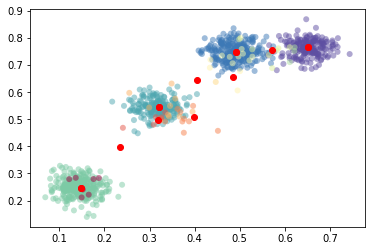

In [ ]:
ax = plt.subplot(1, 1, 1)
ax.scatter(X2[:, 0], X2[:, 1],
            c=np.array(XX2[:,-1].detach().numpy().astype(int), dtype="int"), 
            edgecolor='none', alpha = .5,
            cmap=plt.cm.get_cmap('Spectral'))

#ax.scatter([1, 2, 3], [1, 2, 3])
for j in range(n_clusters):
  for k in range(n_clusters):
    if j >= k:
      cs = (MUS[j] + MUS[k])/2
      ax.plot(cs[0], cs[1], "or")
      #print((MUS[j] + MUS[k])/2)
  
ax.plot(MUS[:,0], MUS[:,1], "or")


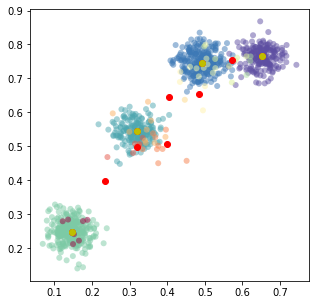

In [ ]:
plt.figure(figsize=[5,5])
ax = plt.subplot(1, 1, 1)
ax.scatter(X2[:, 0], X2[:, 1],
            c=np.array(XX2[:,-1].detach().numpy().astype(int), dtype="int"), 
            edgecolor='none', alpha = .5,
            cmap=plt.cm.get_cmap('Spectral'))

#ax.scatter([1, 2, 3], [1, 2, 3])
for j in range(n_clusters):
  for k in range(n_clusters):
    if j >= k:
      cs = (MUS[j] + MUS[k])/2
      ax.plot(cs[0], cs[1], "or")
      #print((MUS[j] + MUS[k])/2)
  
ax.plot(MUS[:,0], MUS[:,1], "or", color ="y")
plt.show()

In [ ]:
ax.plot()

In [ ]:
MUS

array([[0.14753089, 0.24810738],
       [0.32018946, 0.54524512],
       [0.49178233, 0.74628133],
       [0.65117079, 0.76495979]])

[0.14753089 0.24810738]
[0.23386017 0.39667625]
[0.32018946 0.54524512]
[0.31965661 0.49719436]
[0.40598589 0.64576322]
[0.49178233 0.74628133]
[0.39935084 0.50653358]
[0.48568012 0.65510245]
[0.57147656 0.75562056]
[0.65117079 0.76495979]


In [ ]:
[0.29506178 0.49621476]
[0.46772035 0.7933525 ]
[0.63931322 0.99438871]
[0.79870168 1.01306717]

[0.46772035 0.7933525 ]
[0.64037891 1.09049023]
[0.81197179 1.29152645]
[0.97136024 1.3102049 ]

[0.63931322 0.99438871]
[0.81197179 1.29152645]
[0.98356466 1.49256267]
[1.14295311 1.51124112]

[0.79870168 1.01306717]
[0.97136024 1.3102049 ]
[1.14295311 1.51124112]
[1.30234157 1.52991957]

In [ ]:
fit2 = em_v3(X2, S2, inits2[0], inits2[3], 2000) #diag

# of clusters 4 Converged in Iteration 2001 Likelihood:  tensor(-22.5268, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-22.5365) d0:  tensor(0.9610) BIC:  tensor(362.8104, grad_fn=<AddBackward0>) tensor(137.0537, grad_fn=<MulBackward0>)


In [ ]:
fit2[11][0]

tensor([110.8310, 122.3600, 151.3484, 152.0828], requires_grad=True)

In [ ]:
## get string labels
ss = []
for j in range(n_clusters):
  for k in range(n_clusters):
    if k >= j:
      ss.append( "[{},{}]".format(j, k) )

for j in range(n_clusters):
  ss.append( "{}".format(j) )

In [ ]:
ss

['[0,0]',
 '[0,1]',
 '[0,2]',
 '[0,3]',
 '[1,1]',
 '[1,2]',
 '[1,3]',
 '[2,2]',
 '[2,3]',
 '[3,3]',
 '0',
 '1',
 '2',
 '3']

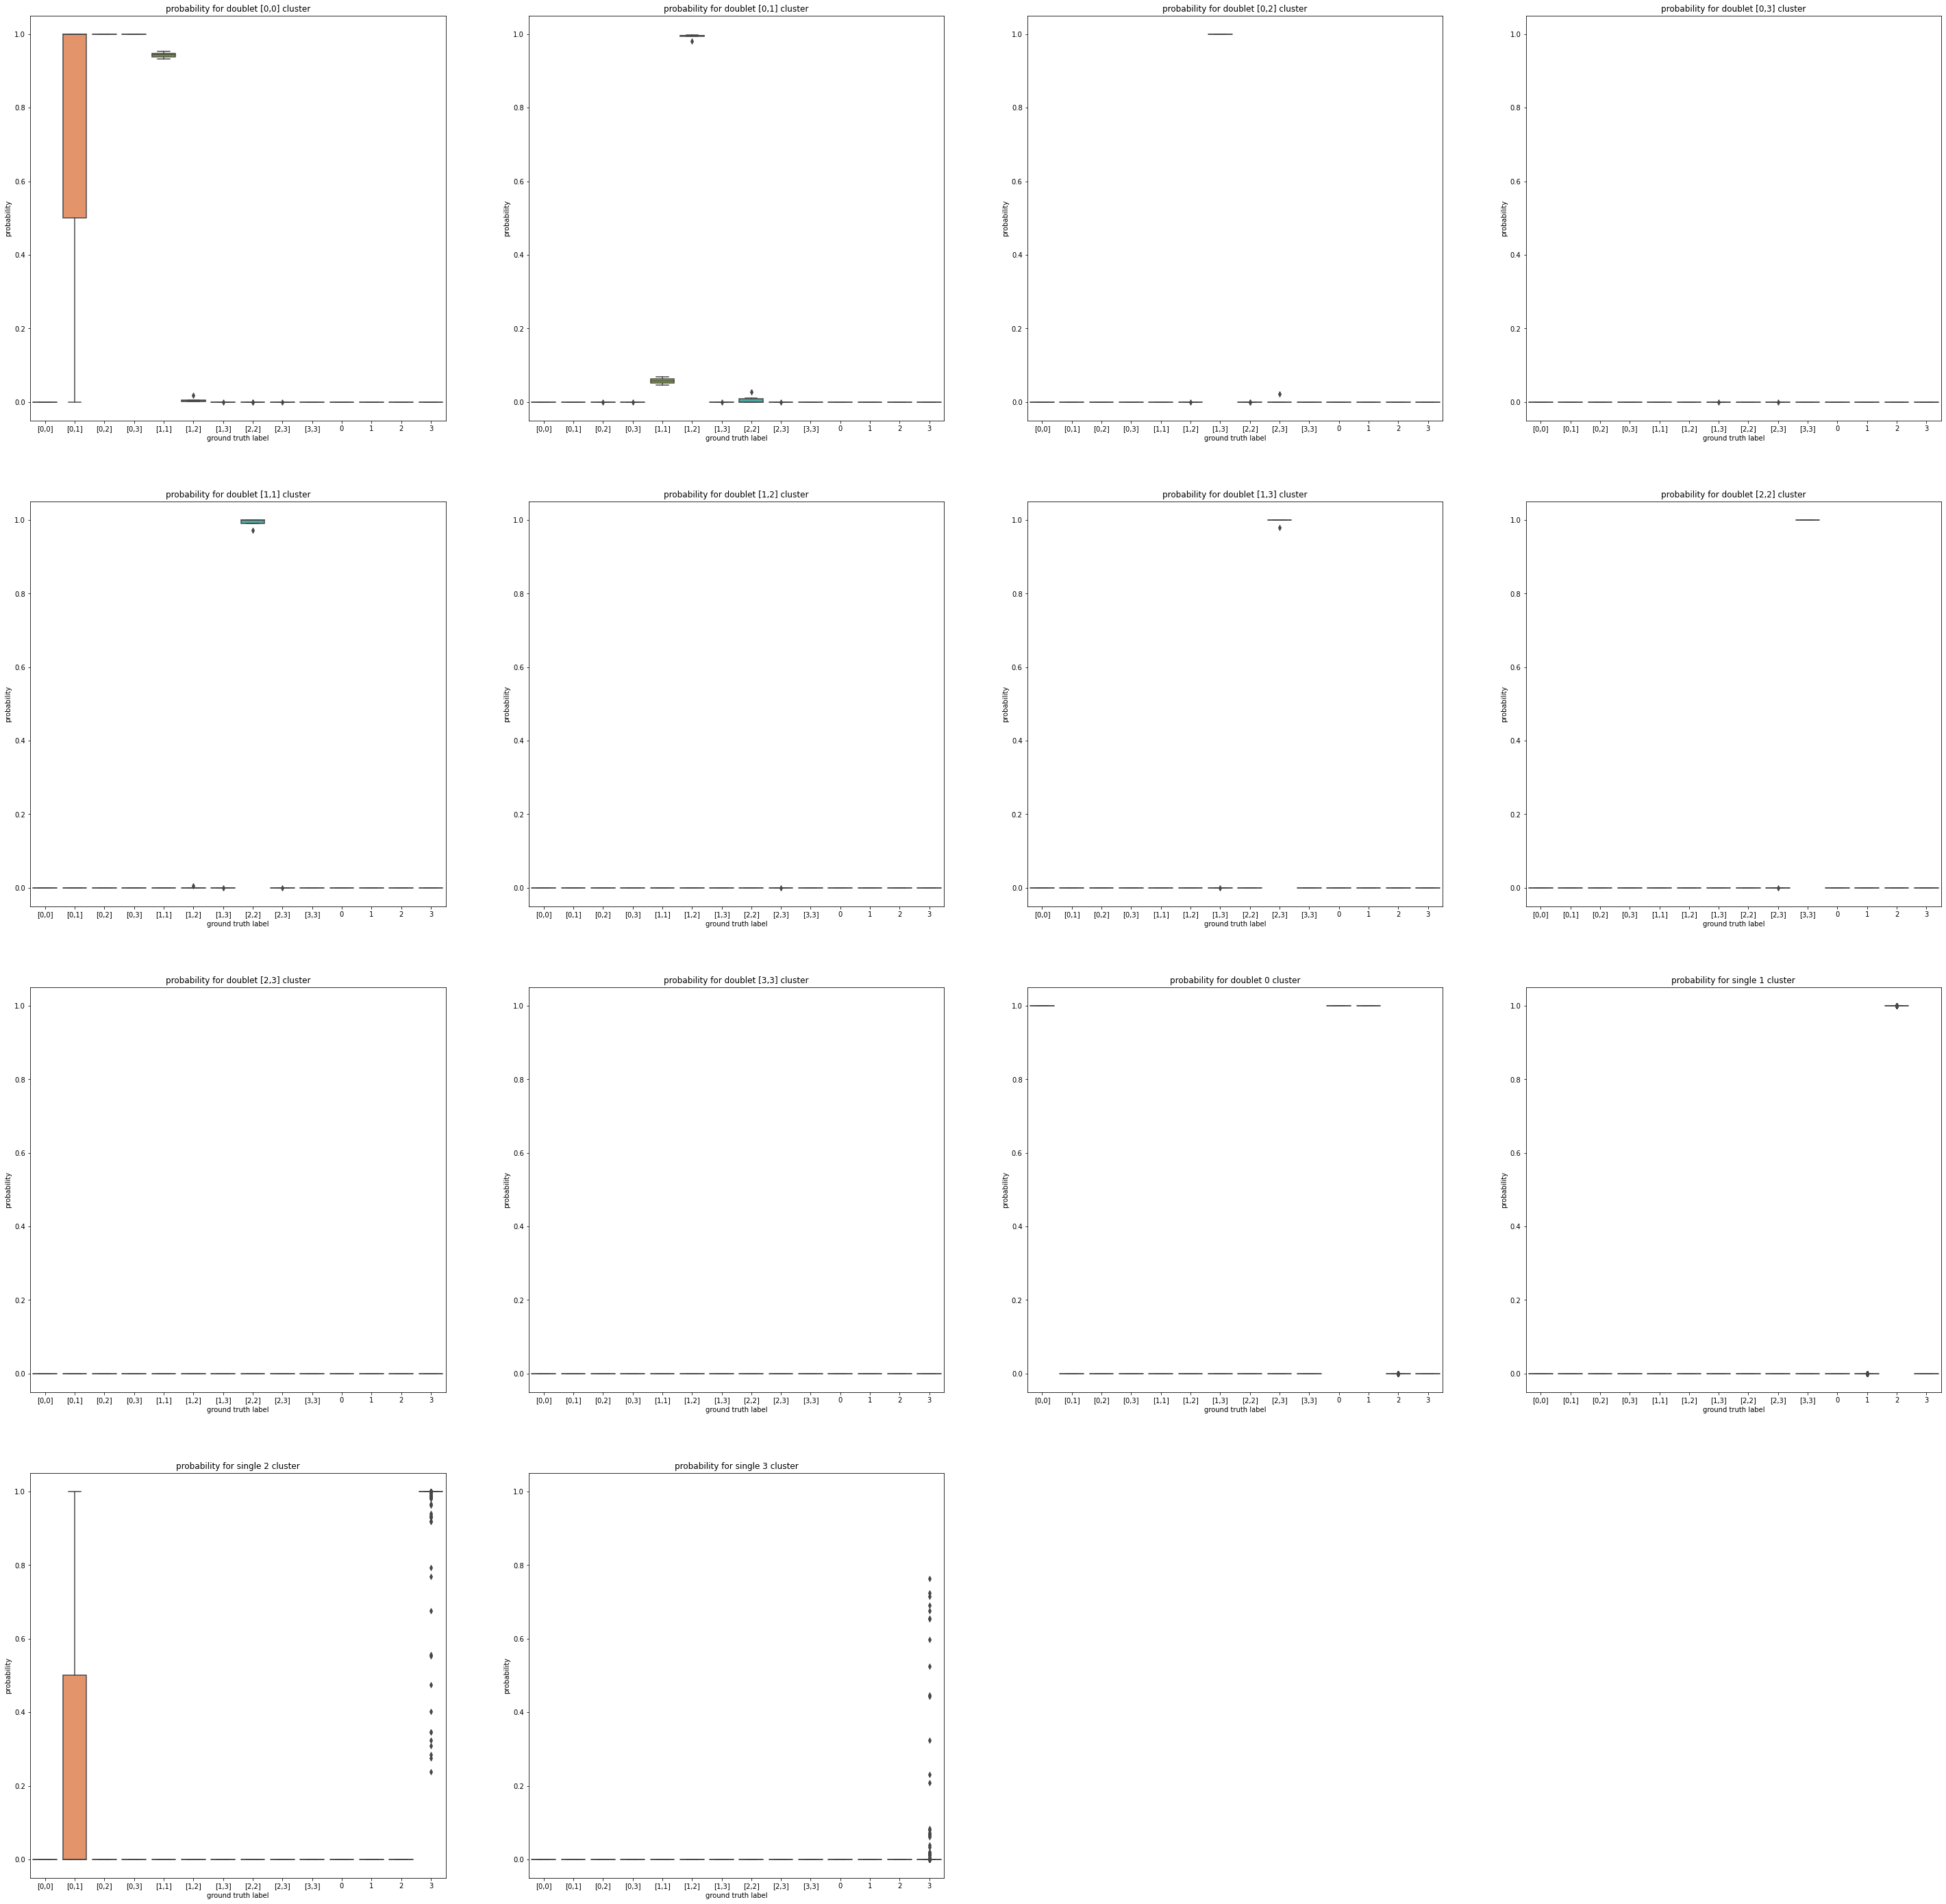

<Figure size 432x288 with 0 Axes>

In [ ]:
#dps = fit[13].reshape(n_obs, n_clusters * n_clusters)
#prob = torch.hstack((dps[:,~torch.isnan(dps[0])], fit[12]))
  
#dps1 = fit1[13].reshape(n_obs, n_clusters * n_clusters)
#prob1 = torch.hstack((dps1[:,~torch.isnan(dps1[0])], fit1[12]))

dps2 = fit2[13].reshape(n_obs, n_clusters * n_clusters)
prob2 = torch.hstack((dps2[:,~torch.isnan(dps2[0])], fit2[12]))

#ss = ['(0,0)','(0,1)','(0,2)','(1,1)','(1,2)','(2,2)','0','1','2']
import seaborn as sns

num_doublet_clusters = int((n_clusters * n_clusters - n_clusters)/2 + n_clusters)
## cluster memberships compared to the truth assignments
plt.figure(figsize=[50,50])
count = 1
for i in range(len(ss)):
  ddd = np.vstack((np.array(XX2[:,-1].numpy(), dtype=int), prob2[:,i].detach().numpy())).T
  plt.subplot(n_clusters, n_clusters, count)
  ax = sns.boxplot(y=ddd[:,1], x=ddd[:,0].astype(int))
  ax.set(xlabel='ground truth label', ylabel= 'probability')
  ax.set_xticklabels(ss)
  ax.set_ylim(-0.05, 1.05)
  if i > num_doublet_clusters:
    ax.set_title("{} {} {}".format('probability for single', ss[i], "cluster"))
  else:
    ax.set_title("{} {} {}".format('probability for doublet', ss[i], "cluster"))
  count += 1
plt.show()
plt.savefig('probsVtruth.png')

In [ ]:
'''
preds[(XX2[:,-3] == 0) & (XX2[:,-2] == 2)]
XX2[(XX2[:,-3] == 0) & (XX2[:,-2] == 2)]

preds = torch.max(prob2, 1).indices
preds[np.array(preds, dtype=int) != np.array(XX2[:,-1].numpy(), dtype=int)]
XX2[:,-1][np.array(preds, dtype=int) != np.array(XX2[:,-1].numpy(), dtype=int)]
'''
#np.savetxt("foo.csv", torch.vstack((torch.max(prob2, 1).indices, XX2[:,-1])).T.numpy(), delimiter=",")

In [ ]:
X2.shape[1]

20

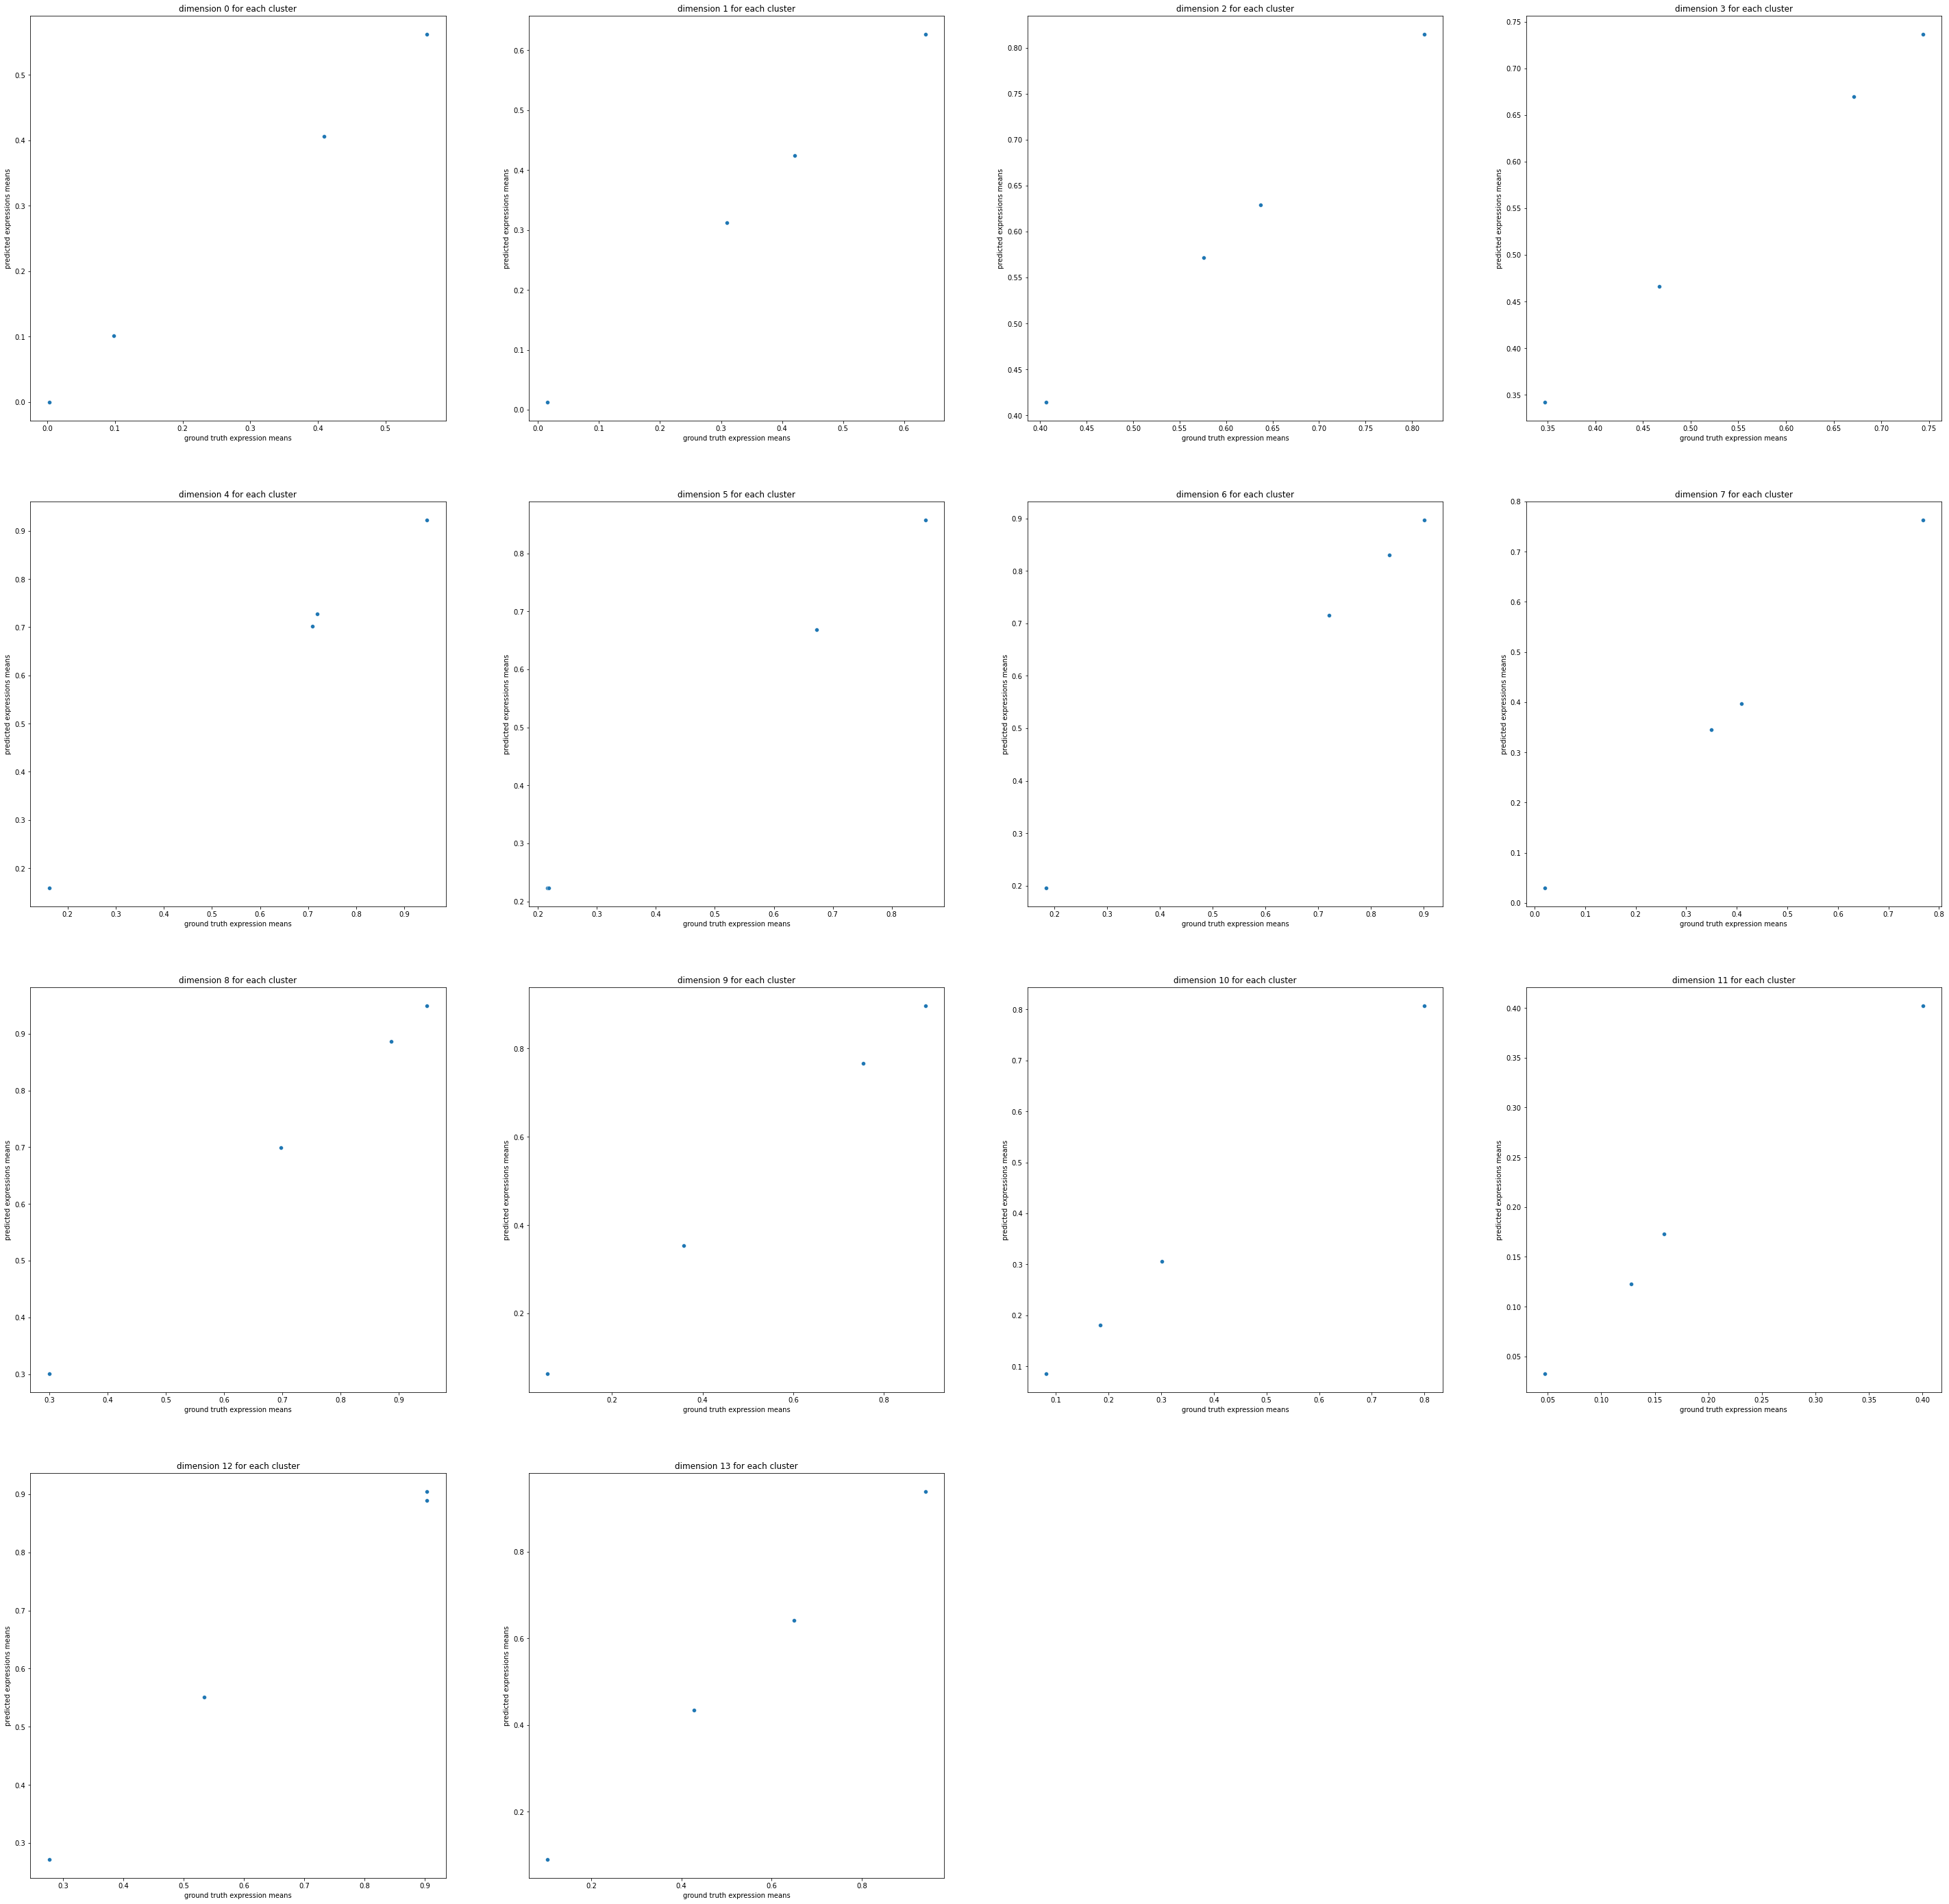

<Figure size 432x288 with 0 Axes>

In [ ]:
## predicted expression mus
plt.figure(figsize=[50,50])
count = 1
for j in range(len(ss)):
  plt.subplot(n_clusters, n_clusters, count)
  ax = sns.scatterplot(x=np.array(MUS[:,j]), y=fit2[11][2][:,j].detach().numpy())
  ax.set_title("{} {} {}".format('dimension', j, "for each cluster"))
  ax.set(xlabel='ground truth expression means', ylabel= 'predicted expressions means')
  count += 1
plt.show()
plt.savefig('emusVtruth.png')

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

In [ ]:
'''
pca = PCA(n_components=2)
components = pca.fit_transform(X2)

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

import plotly.express as px
fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(2),
    color=np.array(XX2[:,-1].detach().numpy().astype(int), dtype="object")
)
fig.update_traces(diagonal_visible=False)
fig.show()

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(2),
    color=np.array(torch.max(prob2,1).indices, dtype="object")
)
fig.update_traces(diagonal_visible=False)
fig.show()
'''

In [ ]:
pca = PCA(2)  # project from 20 to 2 dimensions
projected = pca.fit_transform(X2)
print(X2.shape)
print(projected.shape)

torch.Size([1000, 2])
(1000, 2)


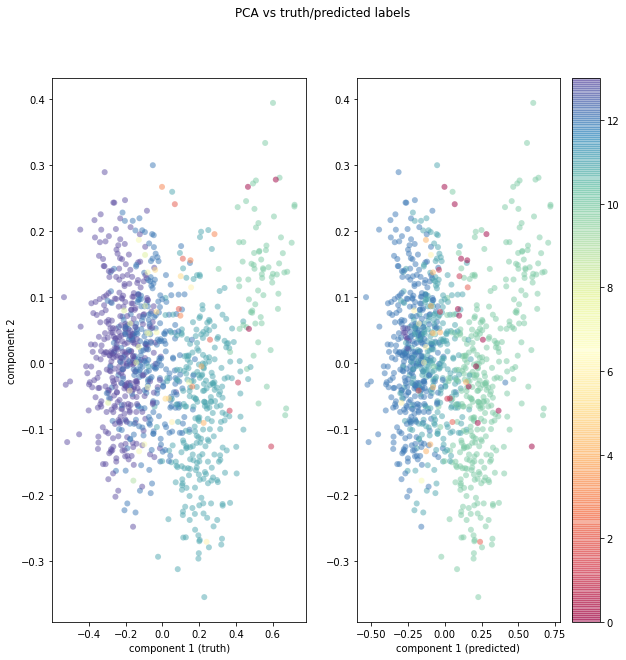

In [ ]:
plt.figure(figsize=[10,10])

plt.suptitle("PCA vs truth/predicted labels") # or plt.suptitle('Main title')

plt.subplot(1, 2, 1)
ax = plt.scatter(projected[:, 0], projected[:, 1],
            c=np.array(XX2[:,-1].detach().numpy().astype(int), dtype="int"), 
            edgecolor='none', alpha = .5,
            cmap=plt.cm.get_cmap('Spectral'))
ax = plt.xlabel('component 1 (truth)')
ax = plt.ylabel('component 2')

plt.subplot(1, 2, 2)
ax = plt.scatter(projected[:, 0], projected[:, 1],
            c=np.array(torch.max(prob2,1).indices, dtype="object"), 
            edgecolor='none', alpha = .5,
            cmap=plt.cm.get_cmap('Spectral'))
ax = plt.xlabel('component 1 (predicted)')

plt.colorbar();

In [ ]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=np.array(torch.max(prob2,1).indices, dtype="object"), 
            edgecolor='none', alpha = .5,
            cmap=plt.cm.get_cmap('Spectral'))
plt.xlabel('component 1')

plt.colorbar();

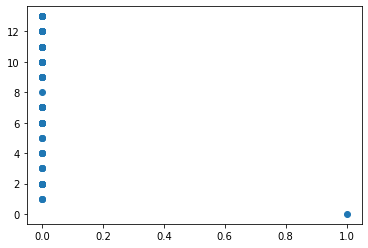

In [ ]:
plt.scatter(prob2[:,0], XX2[:,-1])

In [ ]:
prob2[:,8]

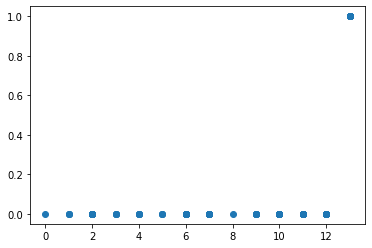

In [ ]:
plt.scatter(XX2[:,-1], prob2[:,13])

In [ ]:
'''
plt.scatter(projected[:, 0], projected[:, 1],
            c=np.array(XX2[:,-1].detach().numpy().astype(int), dtype="int"), 
            edgecolor='none', alpha = .5,
            cmap=plt.cm.get_cmap('Spectral', 13))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

plt.scatter(projected[:, 0], projected[:, 1],
            c=np.array(torch.max(prob2,1).indices, dtype="object"), 
            edgecolor='none', alpha = .5,
            cmap=plt.cm.get_cmap('Spectral', 13))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
'''

In [ ]:
pd.DataFrame(torch.max(prob2,1).indices).value_counts()

12    317
11    317
13    194
10    126
7       7
4       7
2       7
1       6
0       6
9       4
6       4
5       3
3       2
dtype: int64

In [ ]:
pd.DataFrame(XX2[:,-1].detach().numpy().astype(int)).value_counts(asce)

12    317
10    317
13    194
11    126
7       7
5       7
0       7
4       6
1       6
9       4
3       4
2       3
8       1
6       1
dtype: int64

In [ ]:
prob2[np.array(torch.max(prob2,1).indices, dtype="object") != np.array(XX2[:,-1].detach().numpy().astype(int), dtype="int")]

torch.Size([472, 14])

In [ ]:
XX2[:,-1][np.array(torch.max(prob2,1).indices, dtype="object") != np.array(XX2[:,-1].detach().numpy().astype(int), dtype="int")]

tensor([3.], dtype=torch.float64)

In [ ]:
doublet_probs = prob2[XX2[:,-4] == 1]
doublet_data = XX2[[XX2[:,-4] == 1]]

dpca = PCA(2)  # project from 20 to 2 dimensions
dprojected = dpca.fit_transform(doublet_data)


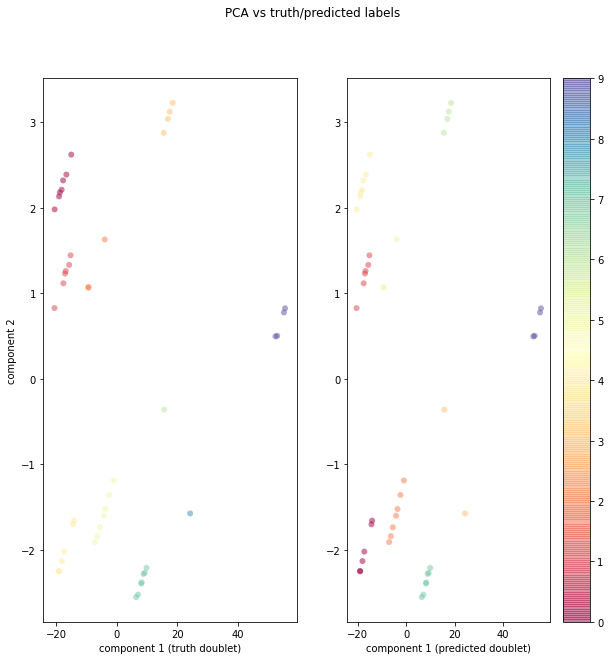

In [ ]:
plt.figure(figsize=[10,10])

plt.suptitle("PCA vs truth/predicted labels") # or plt.suptitle('Main title')

plt.subplot(1, 2, 1)
ax = plt.scatter(dprojected[:, 0], dprojected[:, 1],
            c=np.array(doublet_data[:,-1].detach().numpy().astype(int), dtype="int"), 
            edgecolor='none', alpha = .5,
            cmap=plt.cm.get_cmap('Spectral'))
ax = plt.xlabel('component 1 (truth doublet)')
ax = plt.ylabel('component 2')

plt.subplot(1, 2, 2)
ax = plt.scatter(dprojected[:, 0], dprojected[:, 1],
            c=np.array(torch.max(doublet_probs,1).indices, dtype="object"), 
            edgecolor='none', alpha = .5,
            cmap=plt.cm.get_cmap('Spectral'))
ax = plt.xlabel('component 1 (predicted doublet)')

plt.colorbar();

In [ ]:
X2

tensor([[-0.0164,  0.3250,  0.2373,  ...,  0.3442,  0.2813,  0.2892],
        [ 0.6228,  0.4174,  1.0859,  ...,  0.3488,  0.8787,  0.8912],
        [ 0.1200,  0.0522,  0.2512,  ...,  0.1917,  0.2191,  0.1180],
        ...,
        [ 0.4413,  0.2565,  0.2130,  ...,  0.2816,  0.0913,  0.3632],
        [ 0.3654,  0.1241,  0.3452,  ...,  0.4184,  0.3513,  0.4441],
        [ 0.3035,  0.1305,  0.2150,  ...,  0.3708,  0.2896,  0.4117]],
       dtype=torch.float64)